## VIDEO TO FRAMES

Esta parte del código requiere la ruta donde se aloja el video, y genera los frames de los videos para el Método 1 y Método 2, no es necesario recortar los videos, o eliminar los frames, el código no procesa los primeros y los últimos frames de cada video.

Solo cambiar la ruta del video

In [ ]:
import cv2
import os


# Carpeta con los videos a los que se les quiere extraer los frames
folder_path = (r'D:\Tecnicas_observacionales\Seeing\videos')
filenames = [file for file in os.listdir(folder_path)]

for filename in filenames:
    filename = filename[:-4]
    print(filename)
    
    # Ruta del video
    video_path = (f"videos/{filename}.MOV") # Asume que el video está en una carpeta llamada videos

    # Extraer el nombre del archivo sin la extensión para usar como nombre de la carpeta
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Crear una carpeta con el nombre del video si no existe
    output_folder = os.path.join("frames", video_name)
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
        except OSError:
            print("Error: Creating directory of data")
            exit(1)

    # Abrir el video
    cam = cv2.VideoCapture(video_path)

    # Inicializar el contador de frames
    currentframe = 0

    print(f"\n Inicio de la extracción de frames")

    while True:
        # Leer un frame del video
        ret, frame = cam.read()

        if ret:
            # Si hay frames disponibles, continuar creando imágenes
            name = os.path.join(output_folder, f"frame{currentframe}.jpg")
            # print(f"Creating... {name}")

            # Guardar la imagen extraída
            cv2.imwrite(name, frame)

            # Incrementar el contador de frames
            currentframe += 1
        else:
            print("\n Extracción de frames completada")
            print(f"\n {currentframe} frames generados")
            print(f"          ....            ")
            break

    # Liberar todos los recursos y cerrar ventanas una vez terminado
    cam.release()
    cv2.destroyAllWindows()

## Frames Analysis

Aquí se determina la distancia entre los spot de las estrellas del método 1 y el método 2. 

Se requiere insertar la ruta donde se guardaron los frames

Sarazin & Roddier (1990), definen la varianza en términos del movimiento total como:

$$
\sigma^{2} = 2B_{\alpha}(0,0) = 0.358 \left(\frac{\lambda}{r_0}\right)^{5/3} \left(\frac{\lambda}{D}\right)^{1/3}

$$

Donde $D$ es el diámetro de las aperturas 4.2 cm, $r_0$ es el parámetro de Fried y $\lambda$ es la longitud de onda, en este caso el visible , 0.5 $\mu$ m

Seeing :
$$
FWHM = \Delta \theta = 0.98 \lambda / r_0
$$

In [1]:
Dhole = 42  # diametro de la apertura  en mm
dsep = 144  # diametro de la separacion de las aperturas en mm
lamb = 0.0005  # longitud de onda en micrometros (mm)

In [2]:
"""________________Distance_IMG______________
Programa que construye el histograma de frecuencias de la separación 
entre dos "spots" (objetos) en el DIMM."""

"""_________________Libraries________________________"""
import cv2
import os
import glob
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance as dist
from astropy.stats import mad_std
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from tqdm import tqdm

"""__________________________________________________"""


"""__________________FUNCTIONS_______________________"""
# Definir una función con parámetros de Open CV
def identify_stars_and_distance(image_path, plot=False):
    # Cargar imagen con filtro en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    imagef = image.flatten()
    # Datos de la imagen sin los pixs menores a 5 (fondo presuntamente)
    image_nob = imagef[np.where(imagef>5)]

    # Calcular la desviación estándar (ruido de fondo) de la imagen sin el fondo
    std, median = mad_std(image), np.median(image)
    
    # Aplicar un umbral para binarizar la imagen y destacar los objetos (estrellas) Este parámetro se puede variar según la intensidad de la estrella
    _, thresh = cv2.threshold(image, 3*median , 255, cv2.THRESH_BINARY)

    # Encontrar los contornos de los objetos (estrellas)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar unicamente los dos contornos más grandes detectados (asumiendo que son las estrellas)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # Obtener los centros de las dos estrellas
    star_centers = []  #crear un vector para guardar los centros
    for contour in contours:
        M = cv2.moments(contour) #calcula los momentos del contorno, función de Open CV
        if M["m00"] != 0:  # moo es el area del contorno
            cX = int(M["m10"] / M["m00"])  #m10 es el momento espacial para calcular las coordenadas del centroide
            cY = int(M["m01"] / M["m00"])  #m01 es el momento espacial para calcular las coordenadas del centroide
            star_centers.append((cX, cY)) #guardar las coordenadas de los centros encontrados

    # Calcular la distancia entre las dos estrellas
    if len(star_centers) == 2:
        pixel_distance = dist.euclidean(star_centers[0], star_centers[1])
        if plot:
            # Load the image
            img = mpimg.imread(image_path)
            # Display the image
            plt.imshow(img)
            # print(star_centers)
            plt.plot([star_centers[0][0], star_centers[1][0]], [star_centers[0][1], star_centers[1][1]], 'ro', mfc='none')
            plt.tight_layout()
            plt.axis('off')
            # plt.savefig('hm.png', dpi=400)
            plt.show()        

        return(pixel_distance)
    else:
        # print("No se encontraron estrellas.")
        return 0

    # Mostrar la imagen con los centros de las estrellas marcados
    # plt.imshow(image, cmap='gray')
    # plt.title(f"Distancia en pixeles: {pixel_distance:.2f}")
    # plt.show()


# Definir una funcion para extraer el numero del frame del nombre del archivo
def extract_frame_number(filename):
    match = re.search(r'frame(\d+)\.jpg', filename)
    return int(match.group(1)) if match else -1

"""__________________________________________________"""

"""_____________________SCALE________________________"""

scale_size = 0.358  # segundos de arco por px ('' /px)

Media (mu): 816.218, Desviación estándar (σ): 1.065
En la distribución normal el FWHM está dado por (2.355 * σ): 2.508


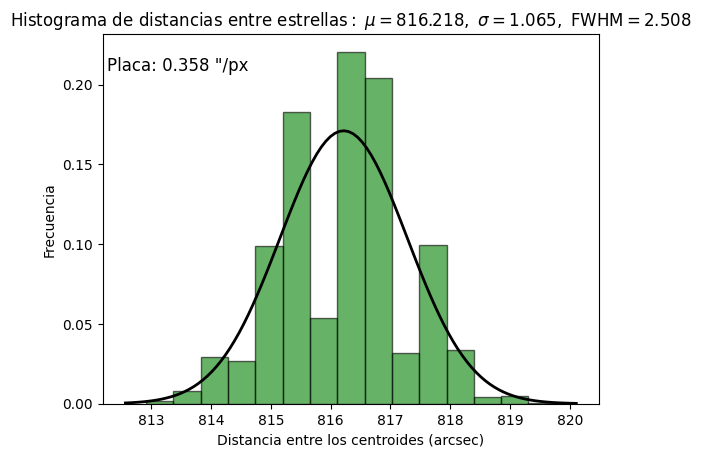

In [11]:
"""_____________________MAIN_________________________"""
folder = (r'D:\Tecnicas_observacionales\Seeing\test')
files = np.sort([file for file in os.listdir(folder)])

values = np.zeros((len(files),6), dtype=object)
ff = -1

seeing = []

for filename in files:
    ff+=1
    
    # Abrir carpeta donde se encuentran los frames del video
    carpeta = f"{folder}/{filename}"
    #print(filename)

    # Busqueda de los archivos .jpg
    archivos = glob.glob(carpeta + r"/*.jpg")

    # Ordenar los archivos numéricamente por el número de frame en el nombre asi (0, 1, 2, 3, ...)
    archivos.sort(key=extract_frame_number)

    # Definir los frames que se procesaran, se escogieron unicamente los frames entre el 40% y el 80% para eliminar errores al inicio y fin
    start = int(len(archivos)*0.4)
    end = int(len(archivos)*0.8)

    nombres = []
    for j in archivos:
        if carpeta in j:
            nombres.append(j.replace(carpeta, ""))


    if nombres != []:
        l = len(nombres)
        #print(f"Procesando {l} archivos .jpg del {start} al {end}")
        #print("\n :: CONSTRUYENDO EL HISTOGRAMA :: \n")
    else:
        print("Su carpeta no tiene archivos .jpg")

    distances = []
    plotit = False

    for k in range(start, end):
        # Usar la función en un frame
        #identify_stars_and_distance(archivos[k])
        #print(f"archivo {archivos[k]}") #verificar si se están ejecutando los frames en orden
        #dis = identify_stars_and_distance(archivos[k], plotit)*scale_size
        dis = identify_stars_and_distance(archivos[k], plotit)

        distances.append(dis)  
        
        if dis!=0:
            plotit=False
    #print(distances)
    distances = np.array(distances)
    no_stars = len(np.where(distances==0)[0])
    #print(f'No se encontraron estrellas en {no_stars} frames, es decir en el {round(no_stars/(end-start+1)*100,2)}% de ellos')

    # Guardar las distancias en un archivo llamado nombre_del_video.dat
    #np.savetxt(f"{filename}.dat", distances, fmt="%.6f", header="Distancias entre estrellas (arcsec)")

    #distances = np.loadtxt(f'{filename}.dat')
    #distances = distances[np.where(distances!=0)]
    
    # Ajuste de los datos a una distribución normal
    mu, std = norm.fit(distances)
    # Normalizar los valores del histograma
    weights = np.ones_like(distances) / len(distances)
    # Graficar el histograma con las distancias
    count, bins, ignored = plt.hist(distances, weights=weights, bins=15, alpha=0.6, color="g", edgecolor="black")

    # Graficar la función de densidad de probabilidad (PDF) ajustada
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # Normalizar la PDF para que se ajuste al histograma
    bin_width = bins[1] - bins[0]
    p_normalized = p * bin_width  # Ajuste el área de la PDF al histograma
    plt.plot(x, p_normalized, "k", linewidth=2)


    # Mostrar los valores de mu y sigma
    print(f"Media (mu): {mu:.3f}, Desviación estándar (σ): {std:.3f}")
    print(f"En la distribución normal el FWHM está dado por (2.355 * σ): {2.355*std:.3F}")

    # Grafico
    plt.title(r"$\mathrm{Histograma\ de\ distancias\ entre\ estrellas:}\ \mu=%.3f,\ \sigma=%.3f,\ \mathrm{FWHM}=%.3f$" % (mu, std, 2.355 * std))
    plt.xlabel("Distancia entre los centroides (arcsec)")
    plt.ylabel("Frecuencia")
    plt.text(0.15, 0.9, f"Placa: {scale_size} \"/px", transform=plt.gca().transAxes, fontsize=12, color='black', ha='center')
    plt.show()

    #Parametro de Fried
    r_0 = (((0.358 * (lamb / std) ** 2) ** 3) / Dhole) ** (1 / 5)

    #print(f"El parametro de Fried es :{r_0}")

    #Seeing sin corregir 
    FWHM = 0.98 * lamb / r_0
    
    seeing.append((filename, FWHM))
    #print(f"El valor del Seeing  es: {FWHM:.3f}")
    # Actualizar la barra de progreso después de procesar cada archivo


In [ ]:
seeing

De esta manera se pueden obtener $\sigma (l)$ y $\sigma (t)$

$$
\sigma_{l}^{2} = \left[1 - 0.541 \left(\frac{d}{D}\right)^{-1/3} \right] \sigma^{2}
$$

$$
\sigma_{t}^{2} = \left[1 - 0.811 \left(\frac{d}{D}\right)^{-1/3} \right] \sigma^{2}
$$

De esta manera:

$$
\sigma (l)^2 = 2\lambda^2[0.179/D_{Hole}^{1/3} - 0.097/d_{sep}^{1/3}]r_0(l)^{-5/3}
$$

$$
\sigma (t)^2 = 2\lambda^2[0.179/D_{Hole}^{1/3} - 0.145/d_{sep}^{1/3}]r_0(t)^{-5/3}
$$

In [ ]:
sq_mu_l = (1 - 0.541 * (dsep / Dhole)**(-1 / 3)) * sq_mu
sq_mu_t = (1 - 0.811 * (dsep / Dhole)**(-1 / 3)) * sq_mu

print(sq_mu_l)
print(sq_mu_t)